In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
from dask.distributed import Client
import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gsw
import scipy.io as sio

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from log_progress import log_progress

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
ASBW_path = os.path.join(data_dir,'external','schmidtko','Antarctic_shelf_data.txt')

In [3]:
import pandas as pd
df = pd.read_csv(ASBW_path,sep="     ",skiprows=1,names=['lon','lat','z','C_T','C_T_STD','ABS_S','ABS_S_STD'],engine='python')
df['T']=gsw.pt_from_CT(df.ABS_S,df.C_T)
df['p']=gsw.p_from_z(df.z,df.lat)
df['S']=gsw.SP_from_SA(df.ABS_S,df.p,df.lon,df.lat)
ds = xr.Dataset.from_dataframe(df)

In [4]:
import xesmf as xe
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)
grd_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
grd_fix = xr.open_dataset(grd_path)
grd['lon_rho']=grd_fix['lon_rho']

grdLR = xr.Dataset()
grdLR['lat'] =  grd.lat_rho[::5,::5]
grdLR['lon'] =  grd.lon_rho[::5,::5]
regridder = xe.Regridder(ds,grdLR,'nearest_s2d', locstream_in=True, locstream_out=False, periodic=True, reuse_weights=True)
ds = regridder(ds)

Reuse existing file: nearest_s2d_1x21467_530x630_peri.nc
using dimensions ('index',) from data variable lon as the horizontal dimensions for this dataset.


In [5]:
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

mask_offshelf = (mask_shelf['Total Antarctica'] == 0) & (grd.mask_rho == 1) & (grd.lat_rho<-65)
mask_onshelf = (mask_shelf['Total Antarctica'] == 1) & (grd.zice==0)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_avg.nc')

temp = xr.open_dataset(temp_path).temp.squeeze()[:,::5,::5]
salt = xr.open_dataset(salt_path).salt.squeeze()[:,::5,::5]
mask = mask_onshelf[::5,::5]

In [6]:
def dropna(ds,mask):
    return ds.where(mask).dropna('eta_rho',how='all').dropna('xi_rho',how='all')
ds = dropna(ds,mask)

In [9]:
from scipy import interpolate

def interp_depth(waom3d,mask2d,grd):
    waom2d = ds.T.copy()
    for i in log_progress(np.arange(grd.xi_rho.size)):
            for j in np.arange(grd.eta_rho.size):
                if mask2d[j,i]:
                    f = interpolate.interp1d(grd.z[:,j,i],waom3d[:,j,i],fill_value='extrapolate',kind='nearest')
                    waom2d[j,i] = f(ds.z[j,i])
        
    return waom2d.where(mask2d)

grdLR['z'] = grd.z[:,::5,::5]

ds['T_WAOM']= interp_depth(dropna(temp,mask),dropna(mask,mask),dropna(grdLR,mask))
ds['S_WAOM']= interp_depth(dropna(salt,mask),dropna(mask,mask),dropna(grdLR,mask))

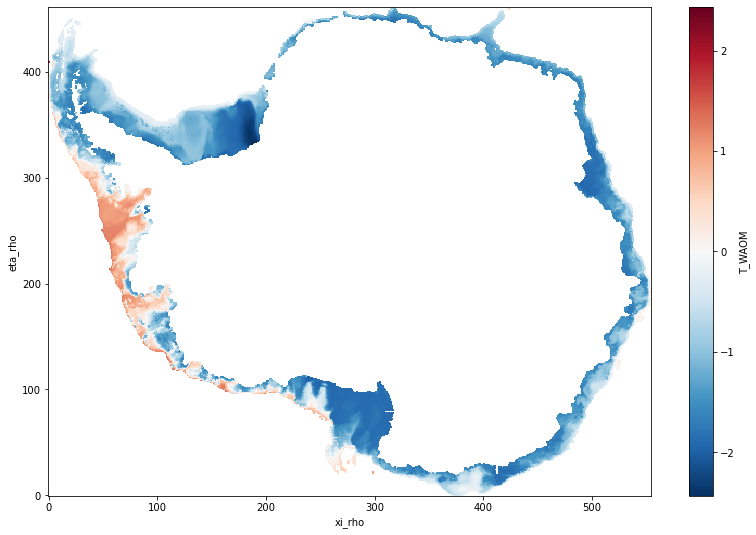

In [10]:
ds.T_WAOM.plot(size=9)

In [11]:
ds['T_diff']=ds.T_WAOM-ds.T
ds['S_diff']=ds.S_WAOM-ds.S

In [17]:
mask_sabrina = dropna(mask_shelf['Sabrina Coast/Aurora subglacial basin'][::5,::5],mask)
mask_wea = dropna(mask_shelf['Western East Antarctica'][::5,::5],mask)
mask_few = (mask_sabrina==1) | (mask_wea==1)
#mask_few = mask_sabrina==1

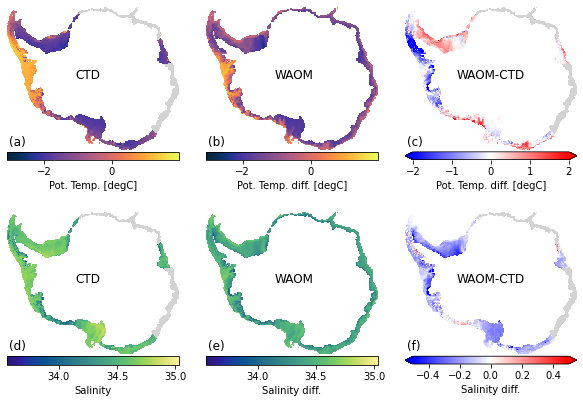

In [20]:
import string

def make_rmse(diff_s):
    return (f' RMSE: {np.sqrt((diff_s**2).mean().values):.3f}')
            #f' MAX:  {diff_s.max().values:.2f}\n'
            #f' MIN:  {diff_s.min().values:.2f}')
def make_mean(diff_s):
    return (f' mean: {diff_s.mean().values:.3f}')
            #f' MAX:  {diff_s.max().values:.2f}\n'
            #f' MIN:  {diff_s.min().values:.2f}')
        
def get_range(da1,da2):
    da_min = min((da1.min(),da2.min()))
    da_max = max((da1.max(),da2.max()))
    
    return da_min,da_max
    
        
Tmin,Tmax = get_range(ds.T,ds.T_WAOM)
Smin,Smax = get_range(ds.S,ds.S_WAOM)

fig = plt.figure(figsize = (8.27, 6.))

ax1 = fig.add_subplot(231)
ds.T.where(mask_few==0).plot(ax=ax1,cmap=ocm.thermal,vmin=Tmin,vmax=Tmax,
          cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [degC]','pad':0.01})

ax2 = fig.add_subplot(232)
ds.T_WAOM.plot(ax=ax2,cmap=ocm.thermal,vmin=Tmin,vmax=Tmax,
               cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax3 = fig.add_subplot(233)
ds.T_diff.where(mask_few==0).plot(ax=ax3,vmin=-2,vmax=2,cmap='bwr',cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax4 = fig.add_subplot(234)
ds.S.where(mask_few==0).plot(ax=ax4,cmap=ocm.haline,vmin=Smin,vmax=Smax,
          cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.01})

ax5 = fig.add_subplot(235)
ds.S_WAOM.plot(ax=ax5,cmap=ocm.haline,vmin=Smin,vmax=Smax,
               cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})

ax6 = fig.add_subplot(236)
ds.S_diff.where(mask_few==0).plot(ax=ax6,vmin=-0.5,vmax=0.5,cmap='bwr',cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})

for ax in [ax1,ax3,ax4,ax6]:
    cmap = matplotlib.colors.ListedColormap(['lightgray','white']) 
    ax.pcolormesh(mask_few.where(mask_few),cmap=cmap)

n=0
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_aspect('equal')
    ax.axis('off')
    #ax.set_xlabel('Salinity (psu)')    
    ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1  
    ax.margins(y=-0.075,x=-0.075)
    
ax1.text(0.4, 0.5, "CTD", transform=ax1.transAxes,size=12)
ax2.text(0.4, 0.5, "WAOM", transform=ax2.transAxes,size=12)
ax3.text(0.3, 0.5, "WAOM-CTD", transform=ax3.transAxes,size=12)
ax4.text(0.4, 0.5, "CTD", transform=ax4.transAxes,size=12)
ax5.text(0.4, 0.5, "WAOM", transform=ax5.transAxes,size=12)
ax6.text(0.3, 0.5, "WAOM-CTD", transform=ax6.transAxes,size=12)

#ax2.text(0.3, 0.35,make_mean(diff['et']),transform=ax2.transAxes,size=10)
#ax3.text(0.3, 0.35,make_mean(diff['wt']),transform=ax3.transAxes,size=10)
#ax5.text(0.3, 0.35,make_mean(diff['es']),transform=ax5.transAxes,size=10)
#ax6.text(0.3, 0.35,make_mean(diff['ws']),transform=ax6.transAxes,size=10)

#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

plt.subplots_adjust(wspace=0.05,hspace=0.01)
plt.tight_layout()
out_path = os.path.join(fig_dir,'Schmidtko_WAOM_ASBW_maps.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [39]:
A.sum()

<xarray.DataArray ()>
array(1.19172789e+11)

In [51]:
def area_mean(data,A,mask):
    A = A.where(mask)
    weights = A/A.sum()
    return (data*weights).sum().values   

A = grd.dx*grd.dy
A = dropna(A[0,::5,::5],mask)

In [52]:
sector={}
masks={}
for key,mask_sec in mask_sector.items():
    print(key)
    mask_sec = dropna(mask_sec[::5,::5],mask)
    sector[key]={}
    for quant in ['T','C_T_STD','T_WAOM','S','ABS_S_STD','S_WAOM']:
        #sector[key][quant]=ds[quant].where(data).mean().values
        sector[key][quant]=area_mean(ds[quant],A,mask_sec)

Total Antarctica
Western East Antarctica
Amery/Prydz Bay
Sabrina Coast/Aurora subglacial basin
George V Coast/Wilkes subglacial basin
Ross Sea
Amundsen Sea
Bellingshausen Sea
Weddell Sea


In [53]:
sec_df= pd.DataFrame(sector,dtype='float').T
sec_df = sec_df.rename({'Sabrina Coast/Aurora subglacial basin':'Sabrina Coast','George V Coast/Wilkes subglacial basin':'George V Coast'})
sec_df = sec_df.drop(['Sabrina Coast','Western East Antarctica'])

In [54]:
sec_df

,T,C_T_STD,T_WAOM,S,ABS_S_STD,S_WAOM
Total Antarctica,-0.866109,0.074910,-0.914672,34.572291,0.011448,34.420238
Amery/Prydz Bay,-1.616644,0.039211,-1.593147,34.474266,0.010740,34.381530
George V Coast,-1.414293,0.084009,-1.092373,34.547709,0.013391,34.404741
Ross Sea,-1.449949,0.040837,-1.234518,34.628546,0.006120,34.465978
Amundsen Sea,0.354045,0.078818,-0.033031,34.543529,0.016165,34.420722
Bellingshausen Sea,1.100043,0.021014,0.250092,34.664791,0.004990,34.499247
Weddell Sea,-1.412546,0.048077,-1.211403,34.599084,0.008358,34.409953


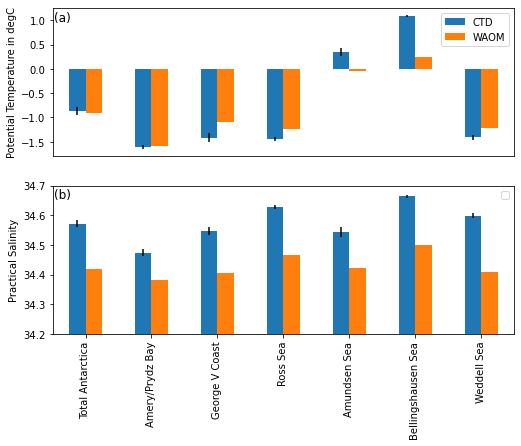

In [74]:
fig,axes = plt.subplots(2,figsize=(8.27,6))
ax1,ax2=axes.flatten()

errors=sec_df.C_T_STD.to_frame('T')
sec_df[['T','T_WAOM']].plot.bar(ax=ax1,yerr=errors)
ax1.set_ylabel('Potential Temperature in degC')
ax1.get_xaxis().set_visible(False)
ax1.legend(['CTD','WAOM'])

errors=sec_df.ABS_S_STD.to_frame('S')
sec_df[['S','S_WAOM']].plot.bar(ax=ax2,yerr=errors)
ax2.set_ylabel('Practical Salinity')
ax2.set_ylim([34.2,34.7])
ax2.legend([])

plt.figtext(0.128,0.85,"(a)",size=12)
plt.figtext(0.128,0.44,"(b)",size=12)

out_path = os.path.join(fig_dir,'Schmidtko_WAOM_ASBW_bars.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [6]:
ds = xr.Dataset()
ds['lon'] = xr.DataArray(data=[220,230,240,250,26, dims=('location'))
ds['lat'] = xr.DataArray(data=[20,30,40,50,60,70], dims=('locations'))

Create weight file: nearest_s2d_1x21467_2650x3150.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


In [5]:
df_extra = df[(df.lon>350) & (df.lon<=360)]
df_extra['lon']=df_extra.lon-360
df_extra
df = df.append(df_extra,ignore_index=True)

df_extra = df[(df.lon>=0) & (df.lon<20)]
df_extra['lon']=df_extra.lon+360
df_extra
df = df.append(df_extra,ignore_index=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
from scipy.interpolate import griddata

def make_da(var):
    lons = df.lon.values
    lats = df.lat.values
    data = df[var].values
    lon2d, lat2d = np.meshgrid(np.arange(0,360.25,0.25),np.arange(-80,-59.75,0.25))

    data2d = griddata((lons,lats), data, (lon2d,lat2d), method='linear')
    da = xr.DataArray(data2d,dims=('lat','lon'),coords={'lat':('lat',np.arange(-80,-59.75,0.25)),'lon':('lon',np.arange(0,360.25,0.25))})
    
    return da

#ds = xr.Dataset({'C_T':make_da('C_T'),'z':make_da('z'),'ABS_S':make_da('ABS_S')})
ds = {}
for key in df.keys()[2:]:
    ds[key]=make_da(key)
ds = xr.Dataset(ds)

In [27]:
ds = xe.util.grid_2d(0,360,0.25,-80,-60,0.25)

In [12]:
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

mask_offshelf = (mask_shelf['Total Antarctica'] == 0) & (grd.mask_rho == 1) & (grd.lat_rho<-65)
mask_onshelf = (mask_shelf['Total Antarctica'] == 1) & (grd.zice==0)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()

In [ ]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,ds,'bilinear',reuse_weights=True, periodic=True, ignore_degenerate=True)
    return regridder(da)

mask_onshelf_ds = regrid(mask_onshelf)

Create weight file: bilinear_2650x3150_80x1440_peri.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


In [33]:
xe.Regridder?

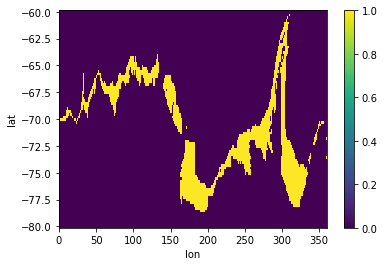

In [139]:
mask_onshelf_ds.plot()

In [13]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,ds,'nearest_s2d',reuse_weights=False)
    return regridder(da)

mask_onshelf_ds = regrid(mask_onshelf)
temp_out = regrid(temp)
salt_out = regrid(salt)
z_out = regrid(grd.z)

mask_sector_ds={}
for key,data in mask_shelf.items():
    mask_sector_ds[key]=regrid(data)

from scipy import interpolate

def interp_depth(waom_out3d,mask_2d):
    waom_out2d = ds.T.copy()
    for lat in log_progress(np.arange(ds.lat.size)):
        for lon in np.arange(ds.lon.size):
            if mask_2d[lat,lon]:
                f = interpolate.interp1d(z_out[:,lat,lon],waom_out3d[:,lat,lon],
                                         fill_value='extrapolate',kind='nearest')
                waom_out2d[lat,lon] = f(ds.z[lat,lon])
        
    return waom_out2d.where(mask_2d)

ds['T_WAOM']= interp_depth(temp_out,mask_onshelf_ds)
ds['S_WAOM']= interp_depth(salt_out,mask_onshelf_ds)

Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc
Reuse existing file: nearest_s2d_2650x3150_81x1441.nc


In [15]:
#put mask on original data
for key,data in ds.items():
    ds[key]=data.where(mask_onshelf_ds)

In [16]:
ds['T_diff']=ds.T_WAOM-ds.T
ds['S_diff']=ds.S_WAOM-ds.S

In [43]:
ax1.set_extent?

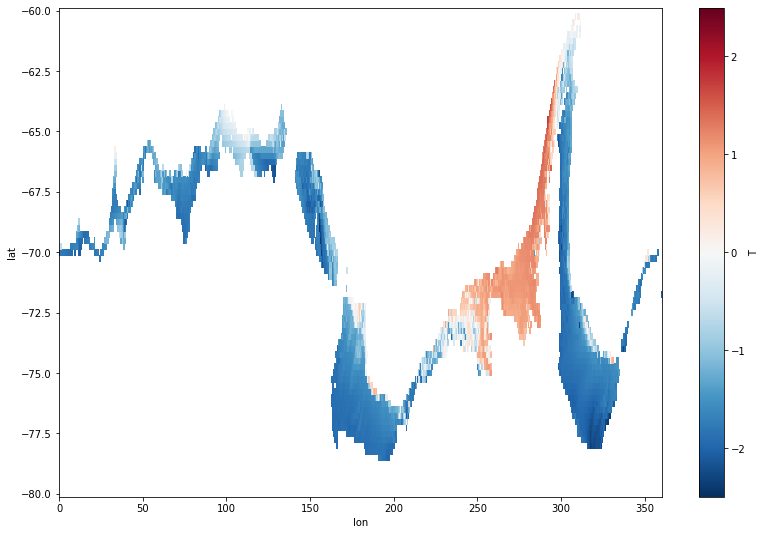

In [131]:
ds.T.plot(size=9)

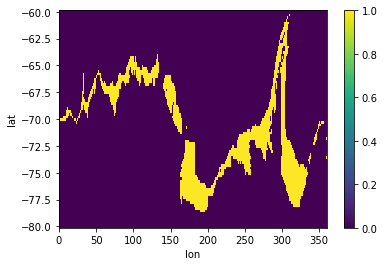

In [137]:
mask_onshelf_ds.plot()

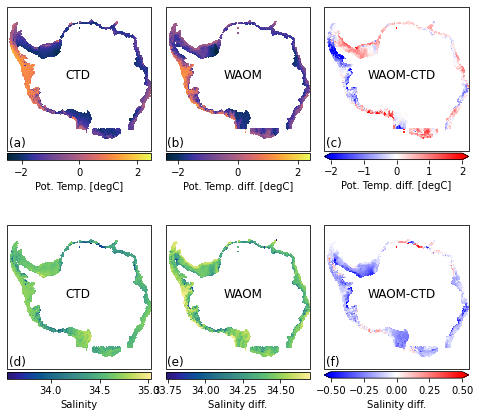

In [136]:
import string

def make_rmse(diff_s):
    return (f' RMSE: {np.sqrt((diff_s**2).mean().values):.3f}')
            #f' MAX:  {diff_s.max().values:.2f}\n'
            #f' MIN:  {diff_s.min().values:.2f}')
def make_mean(diff_s):
    return (f' mean: {diff_s.mean().values:.3f}')
            #f' MAX:  {diff_s.max().values:.2f}\n'
            #f' MIN:  {diff_s.min().values:.2f}')

fig = plt.figure(figsize = (8.27, 8.))

ax1 = fig.add_subplot(231, projection = ccrs.SouthPolarStereo())
ds.T.dropna('lat','all').plot(ax=ax1,transform = ccrs.PlateCarree(),cmap=ocm.thermal,
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [degC]','pad':0.01})

ax2 = fig.add_subplot(232, projection = ccrs.SouthPolarStereo())
ds.T_WAOM.plot(ax=ax2,transform = ccrs.PlateCarree(),cmap=ocm.thermal,
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax3 = fig.add_subplot(233, projection = ccrs.SouthPolarStereo())
ds.T_diff.plot(ax=ax3,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax4 = fig.add_subplot(234, projection = ccrs.SouthPolarStereo())
ds.S.plot(ax=ax4,transform = ccrs.PlateCarree(),cmap=ocm.haline,
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.01})

ax5 = fig.add_subplot(235, projection = ccrs.SouthPolarStereo())
ds.S_WAOM.plot(ax=ax5,transform = ccrs.PlateCarree(),cmap=ocm.haline,
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})

ax6 = fig.add_subplot(236, projection = ccrs.SouthPolarStereo())
ds.S_diff.plot(ax=ax6,transform = ccrs.PlateCarree(),vmin=-0.5,vmax=0.5,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})


n=0
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    #ax.set_xlabel('Salinity (psu)')    
    ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1  
    ax.margins(y=-0.075,x=-0.075)
    
ax1.text(0.4, 0.5, "CTD", transform=ax1.transAxes,size=12)
ax2.text(0.4, 0.5, "WAOM", transform=ax2.transAxes,size=12)
ax3.text(0.3, 0.5, "WAOM-CTD", transform=ax3.transAxes,size=12)
ax4.text(0.4, 0.5, "CTD", transform=ax4.transAxes,size=12)
ax5.text(0.4, 0.5, "WAOM", transform=ax5.transAxes,size=12)
ax6.text(0.3, 0.5, "WAOM-CTD", transform=ax6.transAxes,size=12)

#ax2.text(0.3, 0.35,make_mean(diff['et']),transform=ax2.transAxes,size=10)
#ax3.text(0.3, 0.35,make_mean(diff['wt']),transform=ax3.transAxes,size=10)
#ax5.text(0.3, 0.35,make_mean(diff['es']),transform=ax5.transAxes,size=10)
#ax6.text(0.3, 0.35,make_mean(diff['ws']),transform=ax6.transAxes,size=10)

#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

plt.subplots_adjust(wspace=0.1,hspace=0.01)

out_path = os.path.join(fig_dir,'Schmidtko_WAOM_maps.png')
#fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [27]:
sector={}

for key,data in mask_sector_ds.items():
    sector[key]={}
    for quant in ['T','C_T_STD','T_WAOM','S','ABS_S_STD','S_WAOM']:
        sector[key][quant]=ds[quant].where(data).mean().values

In [92]:
sector.keys()

dict_keys(['Total Antarctica', 'Western East Antarctica', 'Amery/Prydz Bay', 'Sabrina Coast/Aurora subglacial basin', 'George V Coast/Wilkes subglacial basin', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea'])

In [96]:
sec_df= pd.DataFrame(sector,dtype='float').T
sec_df = sec_df.rename({'Sabrina Coast/Aurora subglacial basin':'Sabrina Coast','George V Coast/Wilkes subglacial basin':'George V Coast'})

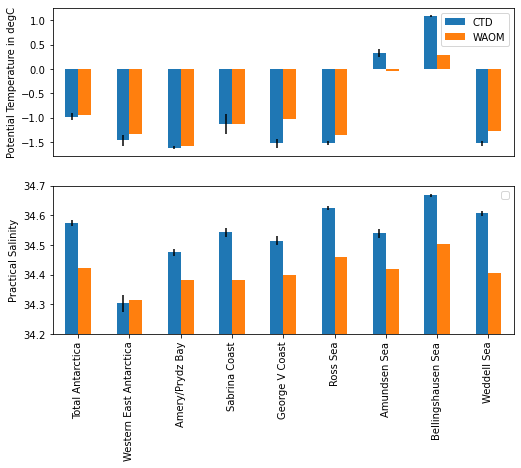

In [130]:
fig,axes = plt.subplots(2,figsize=(8.27,6))
ax1,ax2=axes.flatten()

errors=sec_df.C_T_STD.to_frame('T')
sec_df[['T','T_WAOM']].plot.bar(ax=ax1,yerr=errors)
ax1.set_ylabel('Potential Temperature in degC')
ax1.get_xaxis().set_visible(False)
ax1.legend(['CTD','WAOM'])

errors=sec_df.ABS_S_STD.to_frame('S')
sec_df[['S','S_WAOM']].plot.bar(ax=ax2,yerr=errors)
ax2.set_ylabel('Practical Salinity')
ax2.set_ylim([34.2,34.7])
ax2.legend([])

out_path = os.path.join(fig_dir,'Schmidtko_WAOM_bars.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

<AxesSubplot:>

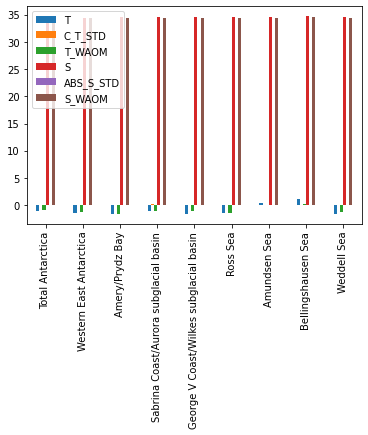

In [73]:
sec_df.plot.bar()

In [22]:
import h5py
CDW_path = os.path.join(data_dir,'external','schmidtko','CDW.mat')
CDW = xr.open_dataset(CDW_path)

In [30]:
CDW.assign_coords({'lon':raw.LONGITUDE,'lat':raw.LATITUDE})

<xarray.Dataset>
Dimensions:    (phony_dim_0: 721, phony_dim_1: 71)
Coordinates:
    lon        (phony_dim_0, phony_dim_1) float64 0.0 0.0 0.0 ... 360.0 360.0
    lat        (phony_dim_0, phony_dim_1) float64 -80.0 -79.5 ... -45.5 -45.0
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    CT_CDW     (phony_dim_0, phony_dim_1) float64 nan nan nan ... 3.093 nan nan
    LATITUDE   (phony_dim_0, phony_dim_1) float64 -80.0 -79.5 ... -45.5 -45.0
    LONGITUDE  (phony_dim_0, phony_dim_1) float64 0.0 0.0 0.0 ... 360.0 360.0
    P_CDW      (phony_dim_0, phony_dim_1) float64 nan nan nan ... 777.9 nan nan
    SA_CDW     (phony_dim_0, phony_dim_1) float64 nan nan nan ... nan nan nan

In [42]:
CT = CDW.CT_CDW.values
SA = CDW.SA_CDW.values
P = CDW.P_CDW.values
PT = gsw.pt_from_CT(SA,CT)
z = gsw.z_from_p(P,CDW.LATITUDE.values)

CDW['PT_CDW']=xr.DataArray(PT)
CDW['Z_CDW']=xr.DataArray(z)

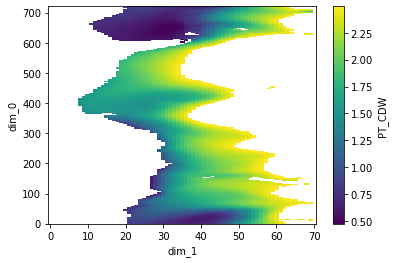

In [46]:
CDW.PT_CDW.plot()

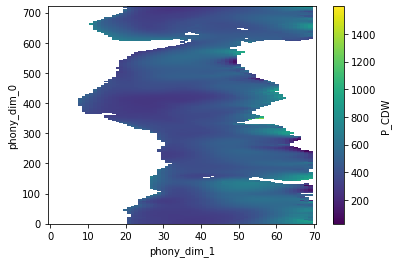

In [32]:


lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

In [26]:
raw.LONGITUDE[:,0]

<xarray.DataArray 'LONGITUDE' (phony_dim_0: 721)>
array([  0. ,   0.5,   1. , ..., 359. , 359.5, 360. ])
Dimensions without coordinates: phony_dim_0
Attributes:
    MATLAB_class:  double

In [18]:
ds = xr.Dataset(
    {
        "CT_CDW": (["lon",'lat'], raw.CT_CDW.values),
        "SA_CDW": (['lon','lat'], raw.SA_CDW.values),
    },
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat),
    },
)

NameError: name 'temp' is not defined